In [1]:
import os, glob, shutil
import openslide
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tifffile as tif
import xml.etree.ElementTree as ET
import scipy
import scipy.ndimage
from shapely.geometry import Polygon
from skimage import draw
import tqdm.notebook as tq

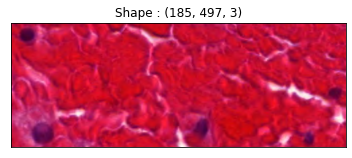

In [97]:
def from_svs(path):
    img = openslide.OpenSlide(path)
    return np.array(img.get_thumbnail(size = img.level_dimensions[0]))/255.0
    
sample_slides = glob.glob('./sample_original/*.svs')
from_svs(sample_slides[0])

img = from_svs(sample_slides[2])
shape = np.array((img.shape[0], img.shape[1]))
plt.imshow(img)
plt.title(f'Shape : {img.shape}')
plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
img = openslide.OpenSlide(sample_slides[0])

In [5]:
img = np.array(img.get_thumbnail(size = img.level_dimensions[0]))/255.0

In [3]:
from mrcnn.config import Config
from mrcnn import model as modellib, utils

class MonuConfig(Config):
    NAME = 'MoNuSAC'
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 4     # Background + 4 cell types
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.8

cfg = MonuConfig()
cfg.display()

Using TensorFlow backend.



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
def generate_masks(src = './MoNuSAC_annotations/', dst_slides = './slides/', dst_masks = './masks/', dst_annots = './annots/', RESET = False, slides = True, masks = True, annots = True):
    '''
    Generates masks for the annotations in the .xml files and saves
    them as .tif files
    Creates three directories: slides/, masks/ and annots/

    '''
    
    if RESET:
        if slides: shutil.rmtree(dst_slides)
        if masks: shutil.rmtree(dst_masks)
        if annots: shutil.rmtree(dst_annots)

    data_path = src
    patients = [x[0] for x in os.walk(data_path)]
    try: 
        if slides: os.mkdir(dst_slides)
        if masks: os.mkdir(dst_masks)
        if annots: os.mkdir(dst_annots)
        
        count = 0
        for patient_loc in tq.tqdm(patients):
            patient_name = patient_loc[len(data_path):] #Patient name
            patient_label = patient_name[8:12]
            sub_images = glob.glob(patient_loc + '/*.svs')

            for sub_image in sub_images:
                img = openslide.OpenSlide(sub_image)
                postfix = '_' + sub_image[-5]

                if slides: shutil.copy(sub_image, './slides/' + patient_label + postfix + '.svs')

                xml_file_name  = sub_image[:-4]
                xml_file_name = xml_file_name+'.xml'
                if annots: shutil.copy(xml_file_name, dst_annots + patient_label + postfix + '_annots.xml')
                tree = ET.parse(xml_file_name)
                root = tree.getroot()

                for k in range(len(root)):
                    label = [i.attrib['Name'] for i in root[k][0]]
                    label = label[0]

                    for child in root[k]:
                        for x in child:
                            r = x.tag
                            if r == 'Attribute':
                                count += 1
                                label = x.attrib['Name']
                                binary_mask = np.transpose(np.zeros((img.read_region((0,0),0,img.level_dimensions[0]).size))) 

                                cell_type_dir = dst_masks + label
                                try: os.mkdir(cell_type_dir)
                                except: pass

                            if r == 'Region':
                                regions = []
                                vertices = x[1]
                                coords = np.zeros((len(vertices), 2))
                                for i, vertex in enumerate(vertices):
                                    coords[i][0] = vertex.attrib['X']
                                    coords[i][1] = vertex.attrib['Y']
                                regions.append(coords)
                                polygon = Polygon(coords)

                                vertex_row_coords = coords[:,0]
                                vertex_col_coords = coords[:,1]
                                fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                                
                                binary_mask[fill_row_coords, fill_col_coords] = 1
                                mask_path = cell_type_dir + '/' + patient_label + '_' + label + '_mask.tif'
                                if masks: cv2.imwrite(mask_path, binary_mask)
                                
    except: 
        print("Directory ./cell_masks or ./slides exists. Please rename or delete in case of conflicting names.")

data_path = './MoNuSAC_annotations/'
generate_masks(src = data_path, 
               RESET = False, 
               slides = True,
               masks = False, 
               annots = False)

  0%|          | 0/47 [00:00<?, ?it/s]

In [86]:
SLIDES = ['./slides/' + filename for filename in os.listdir('./slides')]

ep_mask_filenames = [x[2] for x in os.walk('./masks')][1]
MASKS_EPI = ['./masks/epithelial/' + filename for filename in ep_mask_filenames]

ANNOTS = ['./annots/' + filename for filename in os.listdir('./annots')]

In [87]:
len('./masks/epithelial/')

19

In [106]:
def tif_show(path):
    img = tif.imread(path)
    plt.imshow(img, cmap = "Greys")
    plt.title("Label: " + path[19:19+4])
    plt.xticks([])
    plt.yticks([])
    plt.show()

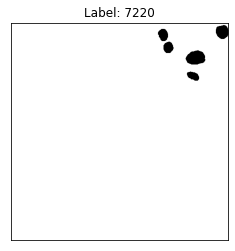

In [107]:
tif_show(MASKS_EPI[8])

In [108]:
patients = [x[0] for x in os.walk(data_path)]
names = [i[len(data_path):] for i in patients]
labels = [name[8:12] for name in names]
patient_names = dict()

for name in names:
    patient_names[name[8:12]] = name

Format of naming 

In [ ]:
def MonuData(utils.Dataset):
    def load(self, dir):
        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")     

        img_path = "./slides/"
        annots_path = "./annots/"
        masks_path = "./masks/"